In [1]:
using DifferentialEquations
using Plots
using LaTeXStrings
pgfplotsx()

Plots.PGFPlotsXBackend()

Consider the simple reaction:

\begin{align}
    A &\longrightarrow B\\
\end{align}

The reaction is elementary, and B acts as a solvent for A and the transition state. We will consider it in a few different solvent environments. 

In [2]:
function batch(du, u, p, t)
    MAR = p["MAR"]
    PAR = p["PAR"]

    k10, K10, NS, V = PAR

    NA   = u[:,1]
    NB   = u[:,2]

    NT     = NA + NB .+ NS
    
    XA   = NA./NT
    XB   = NB./NT
    XS   = NS./NT
    
    #For A in solvent
    A12A = MAR[1]
    
    #For B in solvent
    A12B = MAR[2]
    
    #For Transition State 1 in solvent
    A12TS1 = MAR[3]

    gammaA   = exp.(XS.^2*A12A)
    gammaB   = exp.(XS.^2*A12B)
    gammaTS1 = exp.(XS.^2*A12TS1)

    z1 = 1/K10*gammaB./gammaA.*XB./XA

    r1 = k10*gammaA./gammaTS1.*XA.*(1 .- z1).*NT/V
    
    RA  = -r1[1]
    RB  =  r1[1]
    
    du[1] = RA*V
    du[2] = RB*V
    return du, r1, z1
end

batch (generic function with 1 method)

In [3]:
k10  = 1
K10  = 1
V    = 1

NTOT = 100
NA0  = 0.1
NB0  = 0.0
NS   = 100 - NA0 - NB0

var0     = [NA0 NB0]
span     = (0.0, 2000.0);

In [4]:
#Solvate transition state relative to reactants
MARSET1 = zeros(3,3)
MARSET1[:,1] = [0.0, 0.0,  0.0] #no solvation
MARSET1[:,2] = [0.0, 0.0,  2.0] #destabilize TS1
MARSET1[:,3] = [0.0, 0.0, -2.0] #stabilize TS1

tfine  = 10 .^(range(-5.0, stop = log10(maximum(span)), length = 1000))
Xout   = zeros(length(tfine), size(MARSET1, 2))
r1out  = zeros(length(tfine), size(MARSET1, 2))
z1out  = zeros(length(tfine), size(MARSET1, 2))
NAout  = zeros(length(tfine), size(MARSET1, 2))
NBout  = zeros(length(tfine), size(MARSET1, 2))

for i = 1:size(MARSET1, 2)
    p0   = Dict("MAR" => MARSET1[:,i], "PAR" => [k10, K10, NS, V])
    prob = ODEProblem(batch, var0, span, p0)
    sol  = solve(prob, Rodas5(), abstol = 1e-10, reltol = 1e-10)
    solf = sol(tfine)
    NA   = solf[1,:]
    NB   = solf[2,:]
    NT   = NA + NB .+ NS
    ext  = NB/NA0
    dut, rt1, zt1 = batch([0., 0.], [NA NB], p0, tfine)

    Xout[:,i]  = ext
    r1out[:,i] = rt1
    z1out[:,i] = zt1
    NAout[:,i] = NA
    NBout[:,i] = NB
end

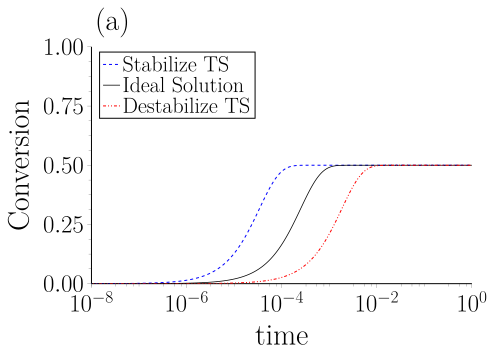

In [5]:
plt1 = plot(
    xscale  = :log10, 
    xlim    = (1e-8, 1),
    xminorticks = 4,
    ylim = (0.0, 1.0),
    yticks = 0.0:0.25:1.0,
    #yticks = (-2.0:1.0:2.0, [@sprintf("%1.1f", x) for x in -2.0:1.0:2.0]),
    yminorticks = 4,
    tick_direction = :out, 
    grid = :off, 
    guidefontsize = 30, 
    tickfontsize = 24,
    xlabel  = "time", 
    ylabel  = "Conversion", 
    fontfamily = "Times Roman",
    legendfontsize = 22,
    legendfonthalign = :left,
    legend  = :topleft,
    title = "(a)",
    titlelocation = :left,
    titlefontsize = 30
)

plt1 = plot!(plt1, tfine/maximum(tfine), Xout[:,3], ls = :dash,       lc = :blue,  lw = 1.00, label = "Stabilize TS")
plt1 = plot!(plt1, tfine/maximum(tfine), Xout[:,1], ls = :solid,      lc = :black, lw = 0.75, label = "Ideal Solution")
plt1 = plot!(plt1, tfine/maximum(tfine), Xout[:,2], ls = :dashdotdot, lc = :red,   lw = 1.00, label = "Destabilize TS")
display(plt1)
savefig(plt1, "CS1d1.pdf")

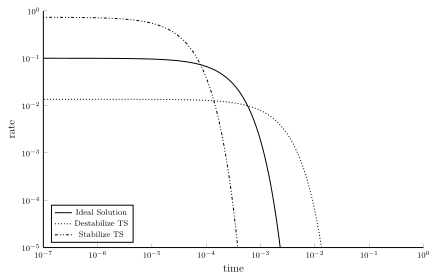

In [6]:
idx1 = r1out[:,1] .> 0
idx2 = r1out[:,2] .> 0
idx3 = r1out[:,3] .> 0

plt2 = plot(tfine[idx1]/maximum(tfine), r1out[:,1][idx1], xscale = :log10, yscale = :log10, ls = :solid, lc = :black, xlabel  = "time", ylabel = "rate", labels = "Ideal Solution", legend = :bottomleft, xlim = (1e-7, 1), ylim = (1e-5, 1), grid = :off)
plt2 = plot!(plt2, tfine[idx2]/maximum(tfine), r1out[:,2][idx2], ls = :dot, lc = :black, label = "Destabilize TS")
plt2 = plot!(plt2, tfine[idx3]/maximum(tfine), r1out[:,3][idx3], ls = :dashdotdot, lc = :black, label = "Stabilize TS")
display(plt2)
savefig(plt2, "CS1d2.pdf")

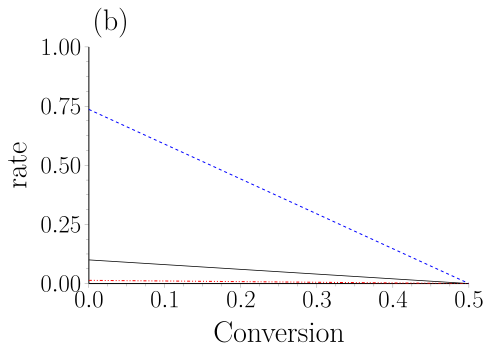

In [7]:
idx1 = r1out[:,1] .> 0
idx2 = r1out[:,2] .> 0
idx3 = r1out[:,3] .> 0

plt3 = plot(
    xlim    = (0.0, 0.5),
    xticks  = 0.0:0.1:0.5,
    xminorticks = 4,
    ylim = (0.0, 1.0),
    yticks = 0.0:0.25:1.0,
    yminorticks = 4,
    tick_direction = :out, 
    grid = :off, 
    guidefontsize = 30, 
    tickfontsize = 24,
    xlabel  = "Conversion", 
    ylabel  = "rate", 
    fontfamily = "Times Roman",
    legendfontsize = 18,
    legendfonthalign = :left,
    legend  = nothing,
    title = "(b)",
    titlelocation = :left,
    titlefontsize = 30
)

plt3 = plot!(plt3, Xout[:,3][idx3], r1out[:,3][idx3], ls = :dash,       lc = :blue,  lw = 1.00, label = "Stabilize TS")
plt3 = plot!(plt3, Xout[:,1][idx1], r1out[:,1][idx1], ls = :solid,      lc = :black, lw = 0.75, label = "Ideal Solution")
plt3 = plot!(plt3, Xout[:,2][idx2], r1out[:,2][idx2], ls = :dashdotdot, lc = :red,   lw = 1.00, label = "Destabilize TS")

display(plt3)
savefig(plt3, "CS1d3.pdf")

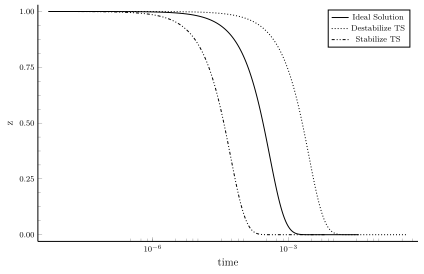

In [8]:
idx1 = z1out[:,1] .< 1.0
idx2 = z1out[:,2] .< 1.0
idx3 = z1out[:,3] .< 1.0

plt4 = plot(tfine[idx1]/maximum(tfine), 1 .- z1out[:,1][idx1], xscale = :log10, ls = :solid, lc = :black, xlabel  = "time", ylabel = "z", label = "Ideal Solution", legend = :topright, grid = :off, minorticks = 4)
plt4 = plot!(plt4, tfine[idx2]/maximum(tfine), 1 .- z1out[:,2][idx2], ls = :dot, lc = :black, label = "Destabilize TS")
plt4 = plot!(plt4, tfine[idx3]/maximum(tfine), 1 .- z1out[:,3][idx3], ls = :dashdotdot, lc = :black, label = "Stabilize TS")
display(plt4)
savefig(plt4, "CS1d4.pdf")

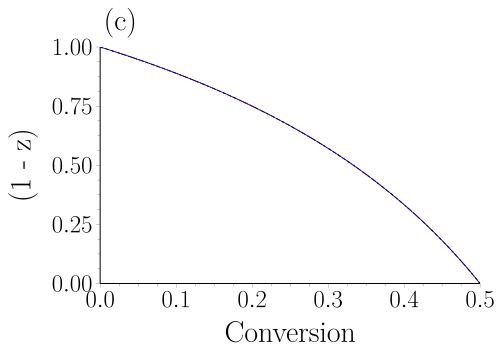

In [9]:
plt5 = plot(
    xlim    = (0.0, 0.5),
    xticks  = 0.0:0.1:0.5,
    xminorticks = 4,
    ylim = (0.0, 1.0),
    yticks = 0.0:0.25:1.0,
    yminorticks = 4,
    tick_direction = :out, 
    grid = :off, 
    guidefontsize = 30, 
    tickfontsize = 24,
    xlabel  = "Conversion", 
    ylabel  = "(1 - z)", 
    fontfamily = "Times Roman",
    legendfontsize = 18,
    legendfonthalign = :left,
    legend  = nothing,
    title = "(c)",
    titlelocation = :left,
    titlefontsize = 30
)

plt5 = plot!(plt5, Xout[:,2], 1 .- z1out[:,2], ls = :dashdotdot, lc = :red,   lw = 1.00, label = "Destabilize TS")
plt5 = plot!(plt5, Xout[:,1], 1 .- z1out[:,1], ls = :solid,      lc = :black, lw = 0.75, label = "Ideal Solution")
plt5 = plot!(plt5, Xout[:,3], 1 .- z1out[:,3], ls = :dash,       lc = :blue,  lw = 1.00, label = "Stabilize TS")
display(plt5)
savefig(plt5, "CS1d5.pdf")

In [10]:
#Solvate transition state relative to reactants
MARSET2 = zeros(3,3)
MARSET2[:,1] = [0.0, 0.0, 0.0] #no solvation
MARSET2[:,2] = [0.0, 2.0, 0.0] #destabilize TS1
MARSET2[:,3] = [0.0, -2.0, 0.0] #stabilize TS1

tfine  = 10 .^(range(-3.0, stop = log10(maximum(span)), length = 1000))
Xout   = zeros(length(tfine), size(MARSET2, 2))
r1out  = zeros(length(tfine), size(MARSET2, 2))
z1out  = zeros(length(tfine), size(MARSET2, 2))
NAout  = zeros(length(tfine), size(MARSET2, 2))
NBout  = zeros(length(tfine), size(MARSET2, 2))

for i = 1:size(MARSET2, 2)
    p0   = Dict("MAR" => MARSET2[:,i], "PAR" => [k10, K10, NS, V])
    prob = ODEProblem(batch, var0, span, p0)
    sol  = solve(prob, Rodas5(), abstol = 1e-18, reltol = 1e-18)
    solf = sol(tfine)
    NA   = solf[1,:]
    NB   = solf[2,:]
    NT   = NA + NB .+ NS
    ext  = NB/NA0
    dut, rt1, zt1 = batch([0., 0.], [NA NB], p0, tfine)

    Xout[:,i]  = ext
    r1out[:,i] = rt1
    z1out[:,i] = zt1
    NAout[:,i] = NA
    NBout[:,i] = NB
end


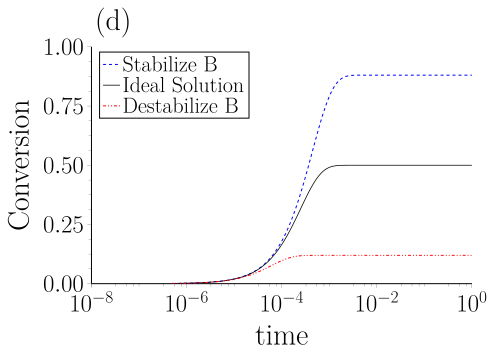

In [11]:
plt6 = plot(
    xscale  = :log10, 
    xlim    = (1e-8, 1),
    xminorticks = 4,
    ylim = (0.0, 1.0),
    yticks = 0.0:0.25:1.0,
    #yticks = (-2.0:1.0:2.0, [@sprintf("%1.1f", x) for x in -2.0:1.0:2.0]),
    yminorticks = 4,
    tick_direction = :out, 
    grid = :off, 
    guidefontsize = 30, 
    tickfontsize = 24,
    xlabel  = "time", 
    ylabel  = "Conversion", 
    fontfamily = "Times Roman",
    legendfontsize = 22,
    legendfonthalign = :left,
    legend  = :topleft,
    title = "(d)",
    titlelocation = :left,
    titlefontsize = 30
)

plt6 = plot!(plt6, tfine/maximum(tfine), Xout[:,3], ls = :dash,       lc = :blue,  lw = 1.00, label = "Stabilize B")
plt6 = plot!(plt6, tfine/maximum(tfine), Xout[:,1], ls = :solid,      lc = :black, lw = 0.75, label = "Ideal Solution")
plt6 = plot!(plt6, tfine/maximum(tfine), Xout[:,2], ls = :dashdotdot, lc = :red,   lw = 1.00, label = "Destabilize B")

display(plt6)
savefig(plt6, "CS1d6.pdf")

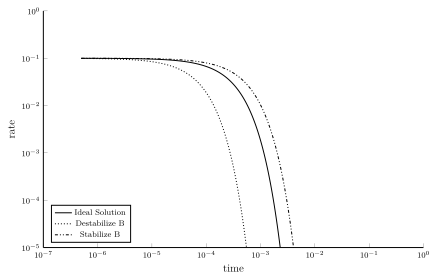

In [12]:
idx1 = r1out[:,1] .> 0
idx2 = r1out[:,2] .> 0
idx3 = r1out[:,3] .> 0

plt7 = plot(tfine[idx1]/maximum(tfine), r1out[:,1][idx1], xscale = :log10, yscale = :log10, ls = :solid, lc = :black, xlabel  = "time", ylabel = "rate", labels = "Ideal Solution", legend = :bottomleft, xlim = (1e-7, 1), ylim = (1e-5, 1), grid = :off)
plt7 = plot!(plt7, tfine[idx2]/maximum(tfine), r1out[:,2][idx2], ls = :dot, lc = :black, label = "Destabilize B")
plt7 = plot!(plt7, tfine[idx3]/maximum(tfine), r1out[:,3][idx3], ls = :dashdotdot, lc = :black, label = "Stabilize B")
display(plt7)
savefig(plt7, "CS1d7.pdf")

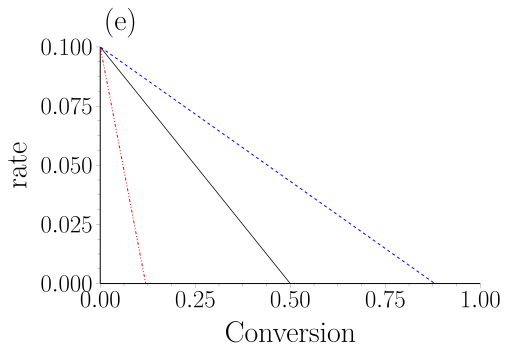

In [13]:
idx1 = r1out[:,1] .> 0
idx2 = r1out[:,2] .> 0
idx3 = r1out[:,3] .> 0

plt8 = plot(
    xlim    = (0.0, 1.0),
    xticks  = 0.0:0.25:1.0,
    xminorticks = 4,
    ylim = (0.0, 0.1),
    yticks = 0.0:0.025:0.1,
    yminorticks = 4,
    tick_direction = :out, 
    grid = :off, 
    guidefontsize = 30, 
    tickfontsize = 24,
    xlabel  = "Conversion", 
    ylabel  = "rate", 
    fontfamily = "Times Roman",
    legendfontsize = 18,
    legendfonthalign = :left,
    legend  = nothing,
    title = "(e)",
    titlelocation = :left,
    titlefontsize = 30
)

plt8 = plot!(plt8, Xout[:,2][idx2], r1out[:,2][idx2], ls = :dashdotdot, lc = :red,   lw = 1.00, label = "Destabilize B")
plt8 = plot!(plt8, Xout[:,1][idx1], r1out[:,1][idx1], ls = :solid,      lc = :black, lw = 0.75, label = "Ideal Solution")
plt8 = plot!(plt8, Xout[:,3][idx3], r1out[:,3][idx3], ls = :dash,       lc = :blue,  lw = 1.00, label = "Stabilize B")
display(plt8)
savefig(plt8, "CS1d8.pdf")

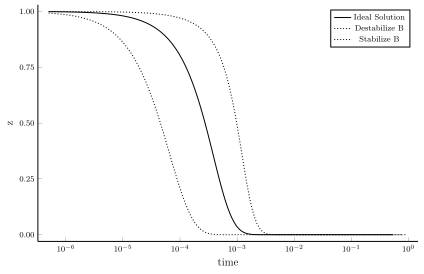

In [14]:
idx1 = z1out[:,1] .< 1.0
idx2 = z1out[:,2] .< 1.0
idx3 = z1out[:,3] .< 1.0

plt9 = plot(tfine[idx1]/maximum(tfine), 1 .- z1out[:,1][idx1], xscale = :log10, ls = :solid, lc = :black, xlabel  = "time", ylabel = "z", label = "Ideal Solution", legend = :topright, grid = :off)
plt9 = plot!(plt9, tfine[idx2]/maximum(tfine), 1 .- z1out[:,2][idx2], ls = :dot, lc = :black, label = "Destabilize B")
plt9 = plot!(plt9, tfine[idx3]/maximum(tfine), 1 .- z1out[:,3][idx3], ls = :dot, lc = :black, label = "Stabilize B")
display(plt9)
savefig(plt9, "CS1d9.pdf")

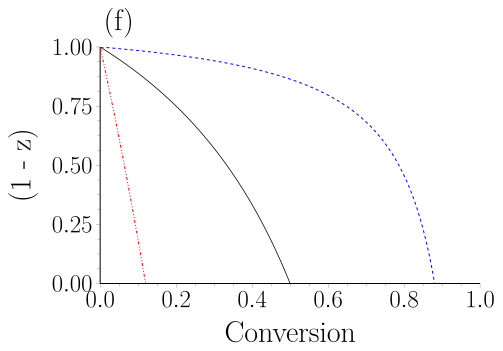

In [15]:
plt10 = plot(
    xlim    = (0.0, 1.0),
    xticks  = 0.0:0.2:1.0,
    xminorticks = 4,
    ylim = (0.0, 1.0),
    yticks = 0.0:0.25:1.0,
    yminorticks = 4,
    tick_direction = :out, 
    grid = :off, 
    guidefontsize = 30, 
    tickfontsize = 24,
    xlabel  = "Conversion", 
    ylabel  = "(1 - z)", 
    fontfamily = "Times Roman",
    legendfontsize = 18,
    legendfonthalign = :left,
    legend  = nothing,
    title = "(f)",
    titlelocation = :left,
    titlefontsize = 30
)

plt10 = plot!(plt10, Xout[:,2], 1 .- z1out[:,2], ls = :dashdotdot, lc = :red,   lw = 1.00, label = "Destabilize B")
plt10 = plot!(plt10, Xout[:,1], 1 .- z1out[:,1], ls = :solid,      lc = :black, lw = 0.75, label = "Ideal Solution")
plt10 = plot!(plt10, Xout[:,3], 1 .- z1out[:,3], ls = :dash,       lc = :blue,  lw = 1.00, label = "Stabilize B")
display(plt10)
savefig(plt10, "CS1d10.pdf")